In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [9]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

<Figure size 1440x720 with 0 Axes>

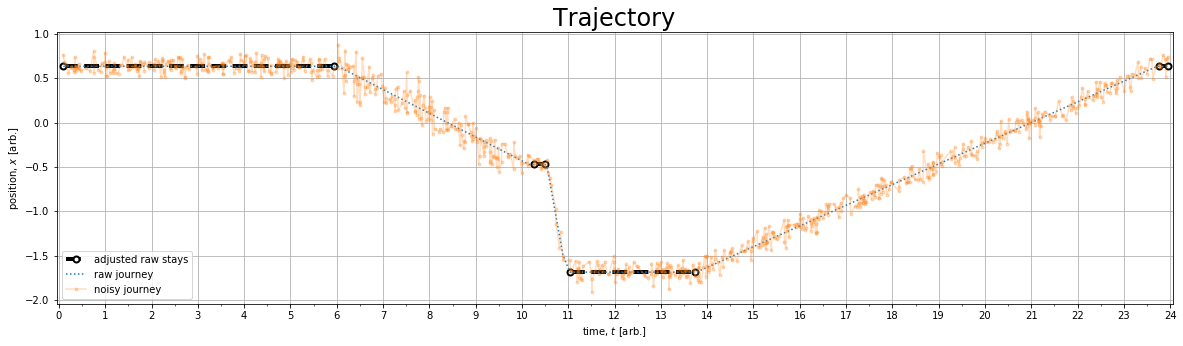

In [10]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [11]:
time_thresh = 1/6
dist_thresh=0.25

In [12]:
clusters = list(range(time_arr.size))

In [13]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [14]:
clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
len(clusters)

19

### IQR-plotting

In [15]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_iqr_mask

In [16]:
clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
len(clusters_rev)

18

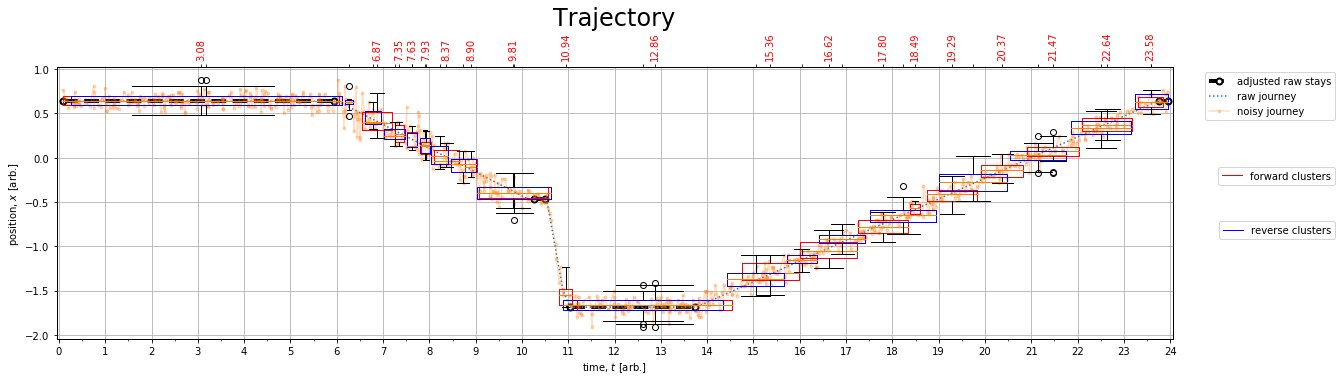

In [19]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

### Refinement with `box_method`

In [20]:
from stay_classification.box_classifier.box_classify import box_classifier_core
from stay_classification.box_classifier.box_method import get_mask, make_box,get_directional_indices

In [21]:
from collections import Counter

In [22]:
def sample_times(indices,frac=0.8):
    return np.sort(np.random.choice(np.array(indices),int(frac*len(indices)), replace=False)).tolist()
    

In [23]:
configs['slope_time_thresh'] = 0.05
configs['slope_thresh'] = abs(dist_thresh/time_thresh)
configs['count_thresh'] = 10
configs['dist_thresh'] = 0.125

start_ind, last_ind = clusters[0][0], clusters[0][-1]

init_pairs = []
final_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    indices = sample_times(range(len(time_arr)),0.99)
    
    start_ind, last_ind, mean, keep = box_classifier_core(time_arr[indices], noise_arr[indices], start_ind, last_ind, timepoint, init_pairs, configs, False)

    if keep:
        final_pairs.append((start_ind, last_ind))
    else:
        continue
    init_pairs.append([cluster[0], cluster[-1]])
    
final_pairs = list(set(final_pairs))
final_pairs

[(261, 319),
 (786, 835),
 (306, 377),
 (288, 340),
 (610, 671),
 (347, 399),
 (549, 620),
 (510, 578),
 (234, 307),
 (404, 542),
 (623, 692),
 (676, 723),
 (800, 845),
 (1, 261),
 (735, 795),
 (232, 305),
 (408, 544),
 (707, 763)]

In [24]:
mid_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    # Get a box for a given timepoint
    mean, start_ind, last_ind = make_box(time_arr, noise_arr, timepoint, configs, False)
            
    mid_pairs.append([start_ind, last_ind,])

mid_pairs

[[1, 272],
 [1, 269],
 [226, 319],
 [226, 323],
 [252, 336],
 [284, 356],
 [301, 391],
 [340, 412],
 [402, 559],
 [401, 559],
 [506, 596],
 [542, 636],
 [604, 684],
 [622, 713],
 [673, 740],
 [702, 782],
 [732, 814],
 [779, 853],
 [799, 861]]

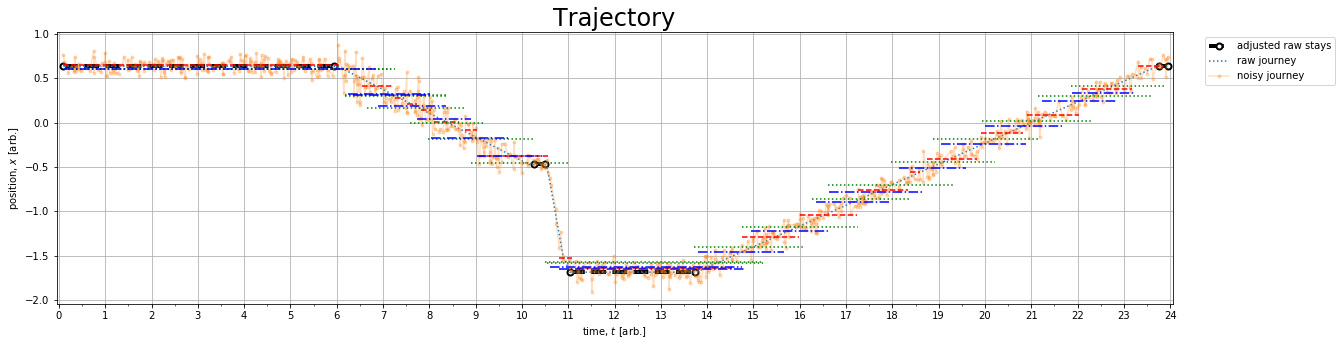

In [25]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])+.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')

for pair in mid_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:')
    
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])-.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);